# Convolutional LSTM One To One Neural Network

Implementing a Convolutional LSTM with 6 entry channels being them `[T_int, Q_heat, T_env, T_prev, mask_interfaces, mask_heaters]`, all in shape `[T, 13, 13]`. It predices the full `T` sequence of the system

## Previous

In [28]:
import os
import sys
import IPython

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Ruta base
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/ia_thermal_colab"
else:
    BASE_PATH = os.path.expanduser("~/ia_thermal_colab")

DATASETS_PATH = os.path.join(BASE_PATH, "datasets")
MODELS_PATH = os.path.join(BASE_PATH, "models")

os.makedirs(DATASETS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print("Modo:", "Colab" if IN_COLAB else "Local")
print("Ruta datasets:", DATASETS_PATH)
print("Ruta modelos:", MODELS_PATH)

Modo: Local
Ruta datasets: C:\Users\ismael.gallo/ia_thermal_colab\datasets
Ruta modelos: C:\Users\ismael.gallo/ia_thermal_colab\models


In [29]:
# 🔄 Parámetros del repo
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia esto
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = os.path.join(BASE_PATH, REPO_NAME)

if IN_COLAB:
    # 🧬 Clonar el repositorio si no existe ya
    if not os.path.exists(CLONE_PATH):
        !git clone {GIT_REPO_URL} {CLONE_PATH}
    else:
        print(f"Repositorio ya clonado en: {CLONE_PATH}")

    # 📦 Instalar requirements.txt
    req_path = os.path.join(CLONE_PATH, "requirements.txt")
    if os.path.exists(req_path):
        !pip install -r {req_path}
    else:
        print("No se encontró requirements.txt en el repositorio.")

    print("🔄 Reinicia el entorno para aplicar los cambios...")
    IPython.display.display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

Importación de librerías necesarias


In [30]:
import numpy as np
import time
from datetime import datetime
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import optuna
from typing import Sequence, Union, Optional
import seaborn as sns


import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal")

from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/ismaelgallo")

from architectures.convlstm import *
from Dataset_Class_convlstm import *

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [32]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

In [33]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

## Dataset import

In [53]:
n_train = 150
n_val = 20
n_test = 2
time_sim = 10 # seconds

batch_size = 64

sequence_length = time_sim+1 # seconds
dt = 1 # seconds
T_init = 298.0 # Kelvin
nodes_side = 13 # number of nodes in one side of the PCB

In [54]:
if IN_COLAB:
  dir_path = BASE_PATH

dataset = load_dataset_convlstm(base_path=dir_path)  

dataset_train = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True)
dataset_val = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True)
dataset_test = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

✅ Cargando ConvLSTM transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset.pth
✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_train.pth
✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_train.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_test.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_

##### Comprobaciones de que no nos estamos cargando nada por el camino

In [55]:
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break  # Solo muestra el primer batch

x_batch shape: torch.Size([64, 11, 6, 13, 13])
y_batch shape: torch.Size([64, 11, 1, 13, 13])


In [56]:
# for i in range(6):
#     print(x_batch[0, 0, i, :, :])

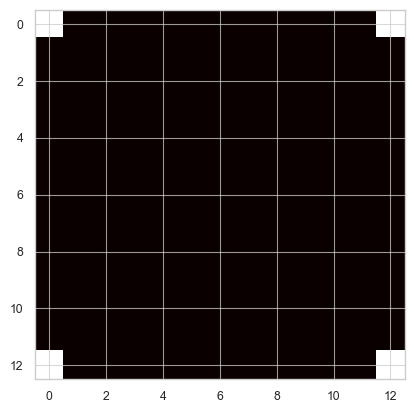

In [57]:
x, _ = next(iter(train_loader))
x = x[0, :, 3, :, :]
x.shape

# plt.imshow(x[0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.imshow(x[-1].cpu().numpy(), cmap='hot', interpolation='nearest')

## Non-phyisics ConvLSTM

### Hyperparameters

In [58]:
epochs = 100
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 100

hidden_dims = [64, 64]  # Número de filtros en cada capa LSTM
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers

### Model definition

Stateful ConvLSTM arquitecture: saves inner state between predictions

In [59]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        # cabeza 1x1 para proyectar el último hidden a 1 canal de temperatura
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)
    
    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: 
            preds  : (B, T, 1, H, W)
            hidden : nuevo estado oculto
        """
        # convlstm devuelve una lista con la salida por capa; tomamos la última
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        # aplano (B*T, C_h, H, W), decode y vuelvo a reshapear
        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)             # (B*T, 1, H, W)
        preds    = dec_flat.view(B, T, 1, H, W)     # (B, T, 1, H, W)

        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de seq_len=1.
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: 
            pred   : (B, 1, 1, H, W)
            hidden : nuevo estado
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden

Model itself

In [60]:
model = PCB_ConvLSTM(input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

# # DEBUGGING
# # Ensure data is moved to the appropriate device
# batch = next(iter(train_loader))
# x, y = batch

# print(f"x está en: {x.device}")
# print(f"y está en: {y.device}")
# print(f"model está en: {next(model.parameters()).device}")

### Training

Bucle de entrenamiento con Scheduled Sampling

In [ ]:
# def train_epoch(model, loader, optimizer, criterion,
#                 epoch, p0=1.0, p_min=0.0, decay_epochs=100):
#     model.train()
#     device = next(model.parameters()).device
#     # decaimiento lineal de p_gt de 1→0 en decay_epochs
#     p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

#     for bc, y in loader:
#         # bc: (B, T, 5, H, W);  y: (B, T, 1, H, W)
#         bc, y = bc.to(device), y.to(device)
#         B, T, _, H, W = y.shape

#         hidden = None
#         loss = 0.0

#         # inicializa con y[:,0] para t=0
#         t_prev = y[:,0]  # (B,1,H,W)

#         for t in range(T):
#             # máscara por muestra para teacher forcing
#             if t == 0:
#                 t_in = t_prev
#             else:
#                 mask = (torch.rand(B,1,1,1,device=device) < p_gt).float()
#                 t_in = mask * y[:,t-1] + (1-mask) * t_prev.detach()

#             # construye input 6 canales
#             x_t = torch.cat([bc[:,t], t_in], dim=1)       # (B,6,H,W)
#             x_t = x_t.unsqueeze(1)                        # (B,1,6,H,W)

#             # paso único
#             pred, hidden = model.forward_step(x_t, hidden)  # pred: (B,1,1,H,W)
#             t_prev = pred[:,0]                              # (B,1,H,W)

#             loss = loss + criterion(t_prev, y[:,t])

#         loss = loss / T
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


Training and saving best model with best parameters.

In [62]:
# Hiper-parámetros de scheduled sampling
p0              = 1.0       # probabilidad inicial de usar GT
p_min           = 0.0       # probabilidad final de usar GT
decay_epochs    = epochs    # en cuántas épocas bajar de p0 a p_min

In [63]:
train_loss = []
val_loss = []
best_val_loss = np.inf
epochs_without_improvement = 0
elapsed_previous = 0.0  # minutos ya entrenados en sesiones anteriores

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = f"{hidden_dims[0]}"
for d in hidden_dims[1:]:
    layer_string += f"-{d}"

model_dir = os.path.join(dir_path, 'models', 'ConvLSTM_6ch', 'stateful_O2O')
if IN_COLAB:
    model_dir = os.path.join(MODELS_PATH, 'ConvLSTM_6ch', 'stateful_O2O')
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = os.path.join(model_dir, filename)
json_path  = model_path.replace('.pth', '.json')

start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- Lógica de reanudación ---
if os.path.exists(model_path):
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            prev = json.load(f)
        best_val_loss         = prev.get('best_val_loss', best_val_loss)
        train_loss            = prev.get('train_loss', [])
        val_loss              = prev.get('val_loss', [])
        elapsed_previous      = prev.get('training_duration_minutes', 0.0)
        start_datetime        = prev.get('start_datetime', start_datetime)
        start_epoch           = prev.get('epochs_trained', 0)
        # Reiniciamos el contador de paciencia tras mejora
        epochs_without_improvement = 0
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

✨ Nuevo entrenamiento: `PCB_ConvLSTM_6ch_nt150_e100_10s_lr0.01_bs64_h64-64_k3x3.pth`

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\stateful_O2O\PCB_ConvLSTM_6ch_nt150_e100_10s_lr0.01_bs64_h64-64_k3x3.json


In [64]:
# --- Bucle de entrenamiento desde start_epoch ---
elapsed_minutes     = elapsed_previous 
start_time_training = time.time() - (elapsed_previous * 60)

for epoch in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()
    p_gt = max(p_min, p0 - epoch*(p0-p_min)/decay_epochs)

    # ——— Entrenamiento ———
    for x_batch, y_batch in tqdm(train_loader,
                                 desc=f"Epoch {epoch+1}/{epochs} - Training",
                                 leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        B, T, _, H, W  = x_batch.shape

        bc_seq = x_batch[:, :, :5]        # (B, T, 5, H, W)
        t_prev = x_batch[:, 0, 5:6]       # (B, 1, H, W)
        hidden = None
        loss_accum = 0.0

        for t in range(T):
            if t == 0:
                t_in = t_prev
            else:
                mask = (torch.rand(B,1,1,1,device=device) < p_gt).float()
                t_in  = mask * y_batch[:,t-1] + (1-mask) * t_prev.detach()

            x_t = torch.cat([bc_seq[:,t], t_in], dim=1).unsqueeze(1)  # (B,1,6,H,W)
            pred_seq, hidden = model(x_t, hidden)
            t_prev = pred_seq[:,0]
            loss_accum += criterion(t_prev, y_batch[:,t])

        loss_batch = loss_accum / T
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        total_loss += loss_batch.item()

    epoch_train_loss = total_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # ——— Validación ———
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            Bv, Tv, _, Hv, Wv = x_val.shape

            bc_v     = x_val[:, :, :5]
            t_prev_v = x_val[:, 0, 5:6]
            hidden_v = None
            val_acc  = 0.0

            for t in range(Tv):
                x_tv = torch.cat([bc_v[:,t], t_prev_v], dim=1).unsqueeze(1)
                pred_v, hidden_v = model(x_tv, hidden_v)
                t_prev_v = pred_v[:,0]
                val_acc += criterion(t_prev_v, y_val[:,t])

            val_loss_batch = val_acc / Tv
            total_val_loss += val_loss_batch.item()

    epoch_val_loss = total_val_loss / len(val_loader)
    val_loss.append(epoch_val_loss)

    # ——— Scheduler ———
    scheduler.step(epoch_val_loss)

    # ——— Early-stopping & Guardado ———
    elapsed_training = time.time() - start_time_training
    elapsed_minutes   = elapsed_training / 60
    current_lr        = optimizer.param_groups[0]['lr']

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss

        # Guardar modelo
        torch.save(model.state_dict(), model_path)

        # — Guardado JSON de hiperparámetros y métricas —
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            'system_specs': system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            'scheduler': {
                'type': 'ReduceLROnPlateau',
                'factor': lrdecay,
                'patience': lrdecay_patience,
                'final_lr': current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_val_loss': best_val_loss,
            'train_loss': list(map(float, train_loss)),
            'val_loss': list(map(float, val_loss)),
        }
        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)

        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stop_patience:
            print(f"⚠️ Early stopping en epoch {epoch+1}")
            break

print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")


Entrenamiento finalizado en 2.75 minutos.


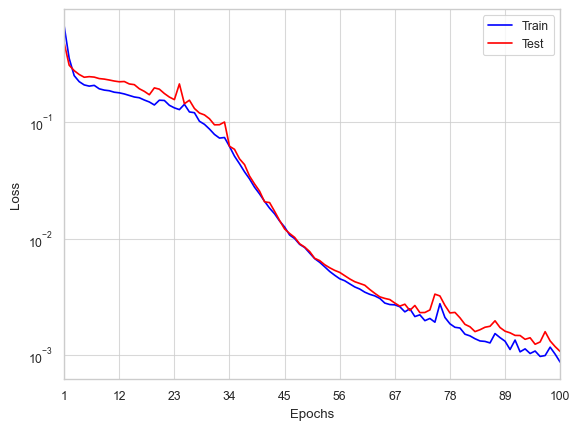

In [65]:
plot_loss_evolution(train_loss, val_loss)

### Testing

In [67]:
# --- 1. Carga del mejor modelo ---
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- 2. Función de rollout autoregresivo puro ---
@torch.no_grad()
def rollout(model, bc_seq, T0):
    """
    bc_seq : (B, T, 5, H, W)  canales de contorno
    T0     : (B, 1, H, W)     temperatura en t=0
    returns : (B, T, 1, H, W) predicciones autoregresivas
    """
    B, T, _, H, W = bc_seq.shape
    preds = []
    t_prev = T0.to(device)
    hidden = None

    for t in range(T):
        x_t = torch.cat([bc_seq[:,t].to(device), t_prev], dim=1)  # (B,6,H,W)
        x_t = x_t.unsqueeze(1)                                    # (B,1,6,H,W)
        pred_seq, hidden = model(x_t, hidden)                     # pred_seq: (B,1,1,H,W)
        t_prev = pred_seq[:,0]                                    # (B,1,H,W)
        preds.append(t_prev)

    # (B, T, 1, H, W)
    return torch.stack(preds, dim=1)

# --- 3. Bucle de test sobre todo test_loader ---
test_losses = []
# (opcional) para ver drift por paso:
step_losses = torch.zeros(sequence_length, device=device)

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        B, T, _, H, W = x_batch.shape

        # separamos contornos y condición inicial
        bc_seq = x_batch[:, :, :5]          # (B, T, 5, H, W)
        T0     = x_batch[:, 0, 5:6]         # (B, 1, H, W)

        # predicción autoregresiva
        y_pred = rollout(model, bc_seq, T0) # (B, T, 1, H, W)

        # pérdida global sobre la secuencia entera
        loss = criterion(y_pred, y_batch)
        test_losses.append(loss.item())

        # (opcional) pérdidas por paso
        # por ejemplo, SSIM o MAE paso a paso
        for t in range(T):
            step_losses[t] += criterion(y_pred[:,t], y_batch[:,t]).item() * B

# cálculo de métricas finales
mean_test_loss = sum(test_losses) / len(test_losses)
step_losses = (step_losses / len(test_loader.dataset)).cpu().numpy()

print(f"▶︎ Test Loss (secuencia completa): {mean_test_loss:.6f}")

# (opcional) imprimir MAE/SSIM en horizontes 1, 5, 10, último
for t_idx in [0, 4, 9, T-1]:
    print(f"  Paso {t_idx+1:2d} Loss: {step_losses[t_idx]:.6f}")


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_6676\719628640.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locati

▶︎ Test Loss (secuencia completa): 0.001081
  Paso  1 Loss: 0.004268
  Paso  5 Loss: 0.000530
  Paso 10 Loss: 0.000381
  Paso 11 Loss: 0.000712


### Analyzing results

In [91]:
def predict_from_conditions(Q_heaters: np.ndarray,
                            T_interfaces: np.ndarray,
                            T_env: float,
                            T_seq_initial: np.ndarray,
                            sequence_length: int,
                            model: PCB_ConvLSTM,
                            dataset: PCBDataset_convlstm,
                            device: torch.device = None) -> np.ndarray:
    """
    Genera una predicción completa de long. sequence_length a partir de:
      - Q_heaters:        (4,)             np.ndarray
      - T_interfaces:     (4,)             np.ndarray
      - T_env:            scalar           float
      - T_seq_initial:    (13,13)          np.ndarray (el mapa inicial)
      - sequence_length:  número de pasos a predecir
      - model:            tu PCB_ConvLSTM cargado y en .eval()
      - dataset:          instancia de PCBDataset_convlstm con create_input_from_values
      - device:           opcional, torch.device

    Devuelve:
      np.ndarray de forma (sequence_length, 13, 13) con la serie desnormalizada.
    """
    
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # 1) Primer input (1,1,6,13,13)
    input0 = dataset.create_input_from_values(
        Q_heaters, T_interfaces, T_env,
        T_seq=np.expand_dims(T_seq_initial, 0),
        sequence_length=sequence_length,
        autorregress=True
    ).to(device)

    # 2) Prepara contornos y t_prev
    # bc_static: (1, seq_len, 5, 13,13)
    bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
    # t_prev: (1,1,1,13,13)
    t_prev = input0[:, :1, 5:6, :, :]

    # 3) Roll-out autoregresivo
    preds_norm = []
    hidden = None
    with torch.no_grad():
        for t in range(sequence_length):
            # concatenar por canal (dim=2)
            x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
            pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
            t_prev = pred_t                                        # mantener shape
            preds_norm.append(t_prev)

    preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

    # 4) Desnormalizar y to numpy
    mean = dataset.T_outputs_mean.to(device)
    std  = dataset.T_outputs_std.to(device)
    preds_denorm = preds_norm * std + mean      # (1, T, 1, H, W)
    preds_denorm = preds_denorm.squeeze(0).squeeze(1)  # (T, 13,13)
    return preds_denorm.cpu().numpy()

In [92]:
model = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_6676\2658188333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(70, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [128]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [129]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 250
T_initial_map = np.full((13, 13), T_init)

Actual values

In [130]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)


Predicted values

In [131]:

# tus valores
# Q_heaters     = np.array([q0, q1, q2, q3])
# T_interfaces  = np.array([ti0, ti1, ti2, ti3])
# T_env         = 20.5
# T_initial_map = np.load('first_slice.npy')  # shape (13,13)
# steps = 50  # número de pasos a predecir

T_pred = predict_from_conditions(
    Q_heaters, T_interfaces, T_env,
    T_initial_map, sequence_length,
    model, dataset, device
)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W) 

print(T_pred.shape)  # (T, 13, 13)

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])
(11, 13, 13)


In [132]:
# T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)
# input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, T_true_tensor, sequence_length=sequence_length, autorregress=True)
# T_true_tensor = T_true_tensor.to('cpu')

# output = model(input_tensor)
# output_denorm = dataset.denormalize_output(output)
# T_pred_tensor = output_denorm[0,:,0,:,:].cpu()
# T_pred = T_pred_tensor.detach().numpy()
# T_pred = infer_sequence(
#     model, dataset, Q_heaters, T_interfaces, T_env, 
#     T_true_tensor, sequence_length, device
# )
# T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to(device)  # (T, H, W)

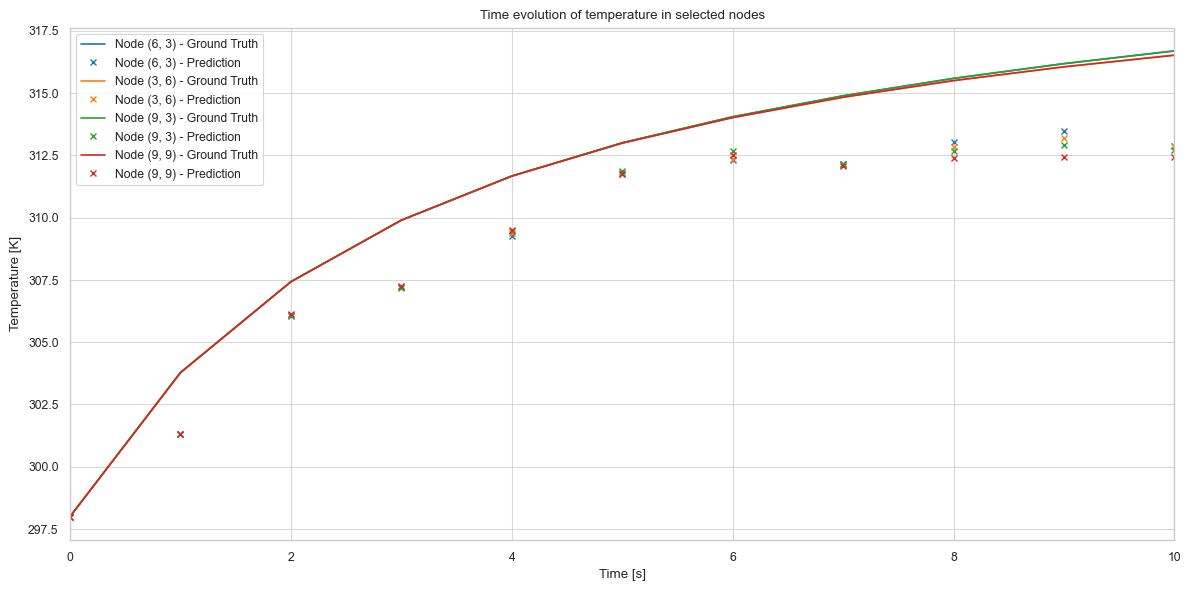

In [133]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True)

Erorr bands

In [134]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 99.52%
Porcentaje de nodos buenos: 97.63%


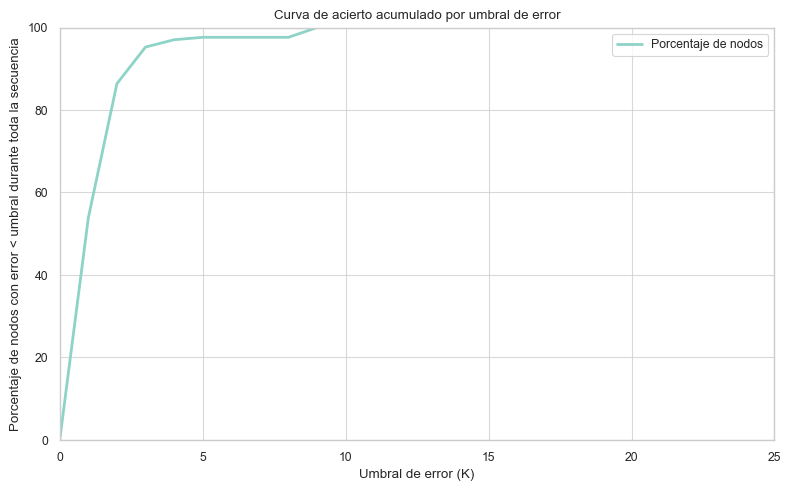

In [135]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Evolución del error con el tiempo

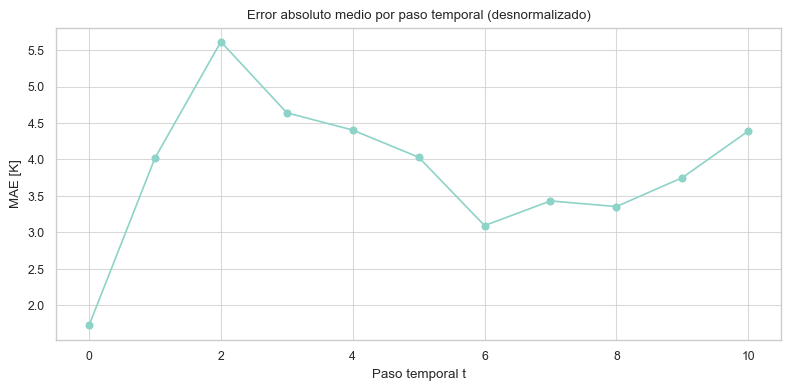

In [138]:
plot_mae_per_frame(T_pred_tensor.detach().cpu(), T_true_tensor.detach().cpu(), dataset)

Error en cada nodo

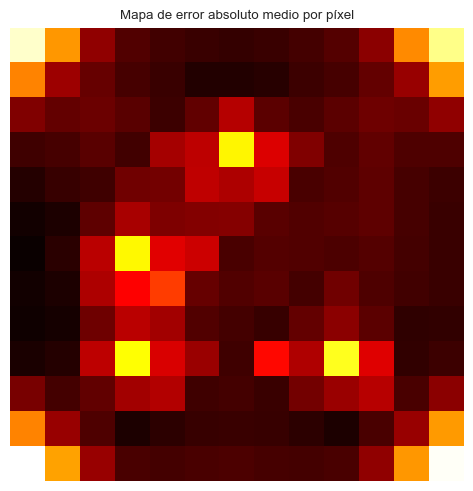

In [140]:
plot_mae_per_pixel(T_pred_tensor.detach().cpu(), T_true_tensor.detach().cpu(), dataset)

Animation of both results

In [141]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='prueba_6ch_comparacion')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\prueba_6ch_comparacion.gif
Gif guardado.


Animation of the error

In [142]:
ani = generar_gif_error_evolucion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='prueba_6ch_error')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook